In [7]:
import matplotlib.pyplot as plt

from pennylane import numpy as np
from tqdm import tqdm
#from qbmqsp.qbm import QBM
from qbmqsp.utils import construct_multi_fcqbm_pauli_strings
from gen_data import xxz_gibbs_state, basis_encoding, gen_boltzmann_dist, gen_discrete_gauss_dist
from qbmqsp.src.utils import import_dataset, split_dataset_labels, split_data

import scipy.linalg as spl

import pennylane as qml
from pennylane import numpy as np
from pennylane.pauli.utils import string_to_pauli_word

from qbmqsp.hamiltonian import Hamiltonian
from qbmqsp.qsp_phase_engine import QSPPhaseEngine
from qbmqsp.qevt import QEVT
from qbmqsp.rel_ent import relative_entropy



import itertools



DATASET_PATH = 'C:/Users/ge84gac/QBM-anomaly-detection/src/datasets/l_o6_c10_d3_p1000_2.npy'   # Give dataset path
CLUSTER = 10

In [8]:

data = import_dataset(DATASET_PATH)
training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)



In [ ]:
# Function returning the hamilatonian form for the restriceted boltzmann machine

In [11]:
def generate_pauli_strings_tfim(num_qubits,n_visible):
    """
    Generate Pauli strings for a transverse field Ising model as a 
    restricted boltzmann machine with no visible-visible connecions.
    
    Parameters:
    num_qubits (int): Number of qubits in the quantum Boltzmann machine.
    n_visible (int): Number if visible units.
    
    Returns:
    list: List of Pauli strings representing the Hamiltonian.
    """
    pauli_strings = []

    # Local transverse field terms (X_i)
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'X'
        pauli_strings.append(''.join(pauli_string))

    # Interaction terms (Z_i Z_j)
    for i, j in itertools.combinations(range(num_qubits), 2):
        if i<n_visible and j>=n_visible:
            pauli_string = ['I'] * num_qubits

            pauli_string[i] = 'Z'
            pauli_string[j] = 'Z'
            pauli_strings.append(''.join(pauli_string))
                
    return pauli_strings

generate_pauli_strings_tfim(5,3)   

['XIIII',
 'IXIII',
 'IIXII',
 'IIIXI',
 'IIIIX',
 'ZIIZI',
 'ZIIIZ',
 'IZIZI',
 'IZIIZ',
 'IIZZI',
 'IIZIZ']

In [14]:


class QBM():
    """Quantum Boltzmann machine (QBM) based on quantum signal processing.

    Parameters
    ----------
    β, enc:
        Same as attributes.
    h, θ:
        See qbmqsp.hamiltonian.Hamiltonian
    δ, polydeg:
        See qbmqsp.qsp_phase_engine.QSPPhaseEngine

    Attributes
    ----------
    β : float
        Inverse temperature.
    enc : str in {'general', 'lcu'}
        Unitary block encoding scheme.
    H : qbmqsp.hamiltonian.Hamiltonian
        Constructed from parameters (h, θ).
    qsp : qbmqsp.qsp_phase_engine.QSPPhaseEngine
        Constructed from parameters (δ, polydeg).
    qevt : qbmqsp.qevt.QEVT
        Quantum eigenvalue transform to realize matrix function f(A) = exp(- τ * |A|). Updated after each training epoch.
    observables : qml.operation.Observable
        Observables w.r.t which the QBM is measured to optimize via gradient descent.
    aux_wire, enc_wires, sys_wires, env_wires : list[int]
        Quantum register wires of quantum circuit that prepares and measures the QBM.
    """
    
    
    
    
    
    def __init__(self,data,h: list[str], θ: np.ndarray[float], enc: str, δ: float, polydeg: int, β: float, hnodes,epochs=1) -> None:
        if β < 0:
            raise ValueError("__init__: β must not be negative.")
        
        self.epochs=epochs
        self.β = β
        self.enc = enc
        self.H = Hamiltonian(h, θ)
        self.qsp = QSPPhaseEngine(δ, polydeg)
        self.qevt = self._construct_qevt()
        self.aux_wire, self.enc_wires, self.sys_wires, self.env_wires = self._construct_wires()
        self.observables = self._construct_obervables()
        
        self.encoded_data, bits_input_vector, num_features = self.binary_encode_data(data, use_folding=True)
        self.dim_input = bits_input_vector * num_features
        
        self.dim_input=n_visible
        self.n_hidden_nodes=hnodes
        
        self.qubits=self.dim_input+self.n_hidden_nodes
        
        
        # weights and biases in terms of the parameter θ
        
        self.weights_visible_to_hidden=np.reshape(θ[self.n_hidden_nodes+self.dim_input:],(self.dim_input,self.n_hidden_nodes))
        
        self.biases_visible=θ[0:self.dim_input]
        
        self.biases_hidden=θ[self.dim_input:self.n_hidden_nodes+self.dim_input]


  
    def binary_encode_data(self,data, use_folding=False):
        """ Encode a numpy array of form [[numpy.int64 numpy.int64] ...] into a
        list of form [[int, int, int, ...], ...].
        Example: encode [[107  73] [113  90] ...] to
        [[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0] .
        """

        # find out how many bits we need for each feature
        number_bits = len(np.binary_repr(np.amax(data)))
        number_features = data.shape[1]

        binary_encoded = ((data.reshape(-1, 1) & np.array(2 **
                          np.arange(number_bits-1, -1, -1))) != 0).astype(np.float32)
        if use_folding:
            return binary_encoded.reshape(len(data), number_features*number_bits), number_bits, number_features
        else:
            return binary_encoded.reshape(len(data), number_features, number_bits), number_bits, number_features
    
    
    def n_qubits(self, registers: str | set[str] = None) -> int:
        """Return number of qubits per registers.
        
        Parameters
        ----------
        registers : str | set[str]
            Quantum registers whose number of qubits should be returned.
            Must be an element from or a subset of {'aux', 'enc', 'sys', 'env'}.

        Returns
        -------
        n : int
            Number of qubits used per registers.
        """
        if registers is None:
            registers = {'aux', 'enc', 'sys', 'env'}
        elif type(registers) == str:
            registers = {registers}
        if not registers.issubset({'aux', 'enc', 'sys', 'env'}):
            raise ValueError("n_qubits: registers must be an element from or a subset of %r." % {'aux', 'enc', 'sys', 'env'})
        
        n = 0
        if 'env' in registers:
            n += self.qevt.n_qubits('sys')
        registers.discard('env')
        if len(registers) != 0:
            n += self.qevt.n_qubits(registers)
        return n

    def _generate_qsp_phases(self) -> np.ndarray[float]:
        τ = self.β / (1-self.qsp.δ) * self.H.θ_norm()
        φ = self.qsp.generate(τ)
        return φ

    def _construct_qevt(self) -> QEVT:
        φ = self._generate_qsp_phases()
        h_δ, θ_δ = self.H.preprocessing(self.qsp.δ)
        return QEVT(h_δ, θ_δ, self.enc, φ)
    
    def _construct_wires(self) -> tuple[list[int], list[int], list[int], list[int]]:
        wires = list(range(self.n_qubits()))
        aux_wire = wires[: self.n_qubits('aux')]
        enc_wires = wires[self.n_qubits('aux') : self.n_qubits({'aux', 'enc'})]
        sys_wires = wires[self.n_qubits({'aux', 'enc'}) : self.n_qubits({'aux', 'enc', 'sys'})]
        env_wires = wires[self.n_qubits({'aux', 'enc', 'sys'}) : self.n_qubits({'aux', 'enc', 'sys', 'env'})]
        return aux_wire, enc_wires, sys_wires, env_wires

    def _construct_obervables(self) -> list[qml.operation.Observable]:
        n_aux_enc = self.n_qubits({'aux', 'enc'})
        aux_enc_wires = self.aux_wire + self.enc_wires
        proj0 = qml.Projector( [0] * n_aux_enc, aux_enc_wires)

        new_sys_wires = list(range(self.n_qubits('sys')))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        observables = [proj0] + [proj0 @ string_to_pauli_word(self.H.h[i], wire_map) for i in range(self.H.n_params)]
        return observables
    
    def _bell_circuit(self) -> None:
        for i, j in zip(self.sys_wires, self.env_wires):
            qml.Hadamard(i)
            qml.CNOT([i, j])

    def _prepare(self) -> None:
        self._bell_circuit()
        self.qevt.circuit(self.aux_wire, self.enc_wires, self.sys_wires)
    
    def _measure(self) -> None:
        return [qml.expval(self.observables[i]) for i in range(len(self.observables))]
    
    def _compute_expvals(self) -> np.ndarray[float]:
        dev = qml.device(dev_name, wires=self.n_qubits())
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
        @qml.qnode(dev)
        def quantum_circuit():
            self._prepare()
            return self._measure()
        
        measurements = quantum_circuit()
        success_probabilty = measurements[0]
        qbm_expvals = measurements[1:] / success_probabilty
        return qbm_expvals
    
    def _loss_func(self, ρ0: np.ndarray[float], ρ1: np.ndarray[float]) -> float:
        return relative_entropy(ρ0, ρ1, check_state=True).item()
    
    def assemble(self) -> np.ndarray[float]:
        """Assemble QBM."""
        expH = spl.expm(-self.β * self.H.assemble())
        return expH / np.trace(expH)
    
    
    
    
    
    
            
    
    def get_average_configurations(self,input_vector=None):
        '''
        Function for giving averge configurations of all qubits for the gibbs state of the system.
        Gives configuration over hidden units only, if input vector is clamped at a certain value.
       
    
        Parameters:
        input vector (np.ndarray)
        
    
        Returns:
        list: List of expectation values of hamilatonian terms.
        '''
        
        
        # unclamped values
        if input_vector is None:
            
            qbm_expvals=self._compute_expvals()
            
            return qbm_expvals
        
        # clamped values
        
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(input_vector,self.weights_visible_to_hidden).flatten()
        #np.matmul(input_vector, self.weights_visible_to_hidden).flatten()
        
        Q_new=new_biases
        
            
        
        β, δ, θ_norm = 1, 0.3, np.linalg.norm(Q_new, ord=1)
        τ = β * θ_norm / (1-δ)
        
        φ = self.qsp.generate(τ)
        #del qsp_phase_engine
         
      
        # New energy configuration only for hidden units
        h=generate_pauli_strings_tfim(self.n_hidden_nodes,self.n_hidden_nodes)
        
        h_δ = h + [self.n_hidden_nodes * 'I']
        θ_δ = np.append(Q_new * (1-δ)/(2*θ_norm), (1+δ)/2)
        encoding='general' 
        qevt = QEVT(h_δ, θ_δ, encoding, φ)
        
        
        
        n_aux, n_enc, n_sys = qevt.n_qubits({'aux'}), qevt.n_qubits({'enc'}), qevt.n_qubits({'sys'})
        wires = list(range(n_aux + n_enc + 2*n_sys))
        aux_wire = wires[: n_aux]
        enc_wires = wires[n_aux : n_aux+n_enc]
        sys_wires = wires[n_aux+n_enc : n_aux+n_enc+n_sys]
        env_wires=wires[n_aux+n_enc+n_sys:]
        
        new_sys_wires = list(range(n_sys))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        proj0 = qml.Projector( [0] * (n_aux+n_enc), aux_wire+enc_wires)
        observables = [proj0] + [proj0 @ string_to_pauli_word(h[i], wire_map) for i in range(len(h))]
        
        
        dev = qml.device(dev_name, wires=n_aux+n_enc+2*n_sys)
        #dev = qml.device(dev_name, backend=backend,wires=n_aux+n_enc+2*n_sys,ibmqx_token=token)
        @qml.qnode(dev)
        
        
        def qevt_circuit():
            for i, j in zip(sys_wires, env_wires):
                qml.Hadamard(i)
                qml.CNOT([i, j])
            qevt.circuit(aux_wire, enc_wires, sys_wires)
            return [qml.expval(observables[i]) for i in range(len(observables))]
       
        measurements = qevt_circuit()
        success_probabilty = measurements[0]
        qbm_expvals = measurements[1:] / success_probabilty    
        
        return qbm_expvals
    

                
    def train_for_one_iteration(self, batch, learning_rate):

        errors = 0
        #errors_biases_visible = 0
        #errors_weights_visible_to_hidden = 0
        #if not self.restricted:
          #  errors_weights_visible_to_visible = 0

        for input_vector in batch:
            
            unclamped_config = self.get_average_configurations() 
            print(unclamped_config)
            clamped_config = self.get_average_configurations(input_vector) # has only expectations over hidden units
            
            # avgs_weights_visible_to_visible_clamped only has a value if not restricted
            print(clamped_config)
            
            # Getting averages for all qubits , avg_visible=input_vector
            
            full_clamped_config=np.zeros_like(unclamped_config)
            
            full_clamped_config[:self.dim_input]=2*input_vector-1        # changing input from [0,1]->[-1,1]
            
            full_clamped_config[self.dim_input:self.dim_input+self.n_hidden_nodes]=clamped_config
            full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.kron(2*input_vector-1,clamped_config)


            errors += full_clamped_config - unclamped_config
            
            
            
            
            
            
            

        errors /= batch.shape[0]
        
        self.H.θ = self.H.θ - learning_rate * errors
                
        self.qevt = self._construct_qevt()
                
       
        
        
        return np.average(errors)
    
    
    
    def train_model(self, batch_size=8, learning_rate=0.005):
        
        data = self.encoded_data
        
        batch_num = data.shape[0] // batch_size
        diff = data.shape[0] % batch_size
        if diff:
            
        
            data = data[:-diff]
            last_batch = data[data.shape[0] - diff:]
        
        
        
        batches = np.vsplit(data, batch_num)
        
        if diff:
            batches.append(last_batch)
              
        
        
        for epoch in range(1, self.epochs+1):
            print(f'Epoch {epoch}')
            batch_errors = None
            batchnum = 1
            errors_f=[]
            for batch in tqdm(batches):
                
                    errors = self.train_for_one_iteration(batch, learning_rate)
                    print(errors)
                    if type(batch_errors) is np.ndarray:
                        batch_errors = np.hstack((batch_errors, errors))
                    else:
                        batch_errors = errors
                    #self.save_weights(
                        #f'e{epoch}_b{batchnum}_{self.paramstring}')
                    batchnum += 1
               
                    #self.save_weights(
                     #   f'e{epoch}_b{batchnum}_{self.paramstring}')
                    #raise e
                    errors_f.append(errors)
        
        return errors_f  
    #self.error_container.add_error(batch_errors)
        #self.error_container.plot("qbm_errors" + self.paramstring)
        #self.save_weights(title="final_weights_qbm" + self.paramstring)
        # make list of values of the error dicts
        
        #self.calculate_outlier_threshold(self.quantile)
       
        
    
        
        
    
        
    
      

In [16]:
#dev_name='qiskit.ibmq'

import numpy
training_data=numpy.expand_dims(training_data[:,0],axis=1)

n_hidden_units=3
n_visible=7
n_qubits = n_visible+n_hidden_units

h = generate_pauli_strings_tfim(n_qubits,n_visible)
print(h)
nparams = len(h)
np.random.seed(seed=1)
θ_init = np.random.random(nparams) / nparams
enc = 'general'
δ = 0.2
polydeg = 7
β = 1.0
learning_rate = 0.05
epochs = 1


dev_name='default.qubit'


qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs)

qbm.train_model(2,0.01)

['XIIIIIIIII', 'IXIIIIIIII', 'IIXIIIIIII', 'IIIXIIIIII', 'IIIIXIIIII', 'IIIIIXIIII', 'IIIIIIXIII', 'IIIIIIIXII', 'IIIIIIIIXI', 'IIIIIIIIIX', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ', 'IZIIIIIZII', 'IZIIIIIIZI', 'IZIIIIIIIZ', 'IIZIIIIZII', 'IIZIIIIIZI', 'IIZIIIIIIZ', 'IIIZIIIZII', 'IIIZIIIIZI', 'IIIZIIIIIZ', 'IIIIZIIZII', 'IIIIZIIIZI', 'IIIIZIIIIZ', 'IIIIIZIZII', 'IIIIIZIIZI', 'IIIIIZIIIZ', 'IIIIIIZZII', 'IIIIIIZIZI', 'IIIIIIZIIZ']

Starting MATLAB engine.. Done.

Epoch 1


  0%|                                                                                                       | 0/252 [00:00<?, ?it/s]

[-2.07455118e-02 -3.66112164e-02 -5.64480056e-06 -1.53266206e-02
 -7.37697383e-03 -4.59594370e-03 -9.27098532e-03 -1.77206937e-02
 -2.06321051e-02 -2.78153599e-02 -1.79974101e-02 -3.17864112e-02
 -4.67523305e-03 -4.27875722e-02  6.07967343e-03 -3.17090988e-02
 -1.83342892e-02 -2.55664633e-02 -2.07781511e-03 -3.45099380e-03
 -3.60358669e-02 -4.53397239e-02 -1.02629460e-02 -2.98810499e-02
 -4.00561156e-02 -4.41976417e-02 -8.73453742e-04  2.20295572e-03
 -5.12235304e-03 -4.27447863e-02  8.22080421e-04]
[-0.01126369 -0.0125823  -0.01466229]
[-2.07455118e-02 -3.66112164e-02 -5.64480056e-06 -1.53266206e-02
 -7.37697383e-03 -4.59594370e-03 -9.27098532e-03 -1.77206937e-02
 -2.06321051e-02 -2.78153599e-02 -1.79974101e-02 -3.17864112e-02
 -4.67523305e-03 -4.27875722e-02  6.07967343e-03 -3.17090988e-02
 -1.83342892e-02 -2.55664633e-02 -2.07781511e-03 -3.45099380e-03
 -3.60358669e-02 -4.53397239e-02 -1.02629460e-02 -2.98810499e-02
 -4.00561156e-02 -4.41976417e-02 -8.73453742e-04  2.20295572e-03
 -

  0%|▎                                                                                            | 1/252 [00:50<3:29:15, 50.02s/it]

-0.046552480392262195


  0%|▎                                                                                            | 1/252 [00:59<4:10:03, 59.78s/it]


KeyboardInterrupt: 

In [99]:

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator
token='7089c69e152319c2983107e1bd382b27a1e557436065c1883a7c8646eccb2fee44b5deeb5ee36cb954051037b37722f69c4da072ca1b0efee6a3c7ac3fc410f3'
service = QiskitRuntimeService(channel='ibm_quantum',token=token)
backend='ibm_kyoto'
with Session(service=service, backend=backend) as session:
    
    qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs)
    a=qbm.train_model(2,0.01)

Epoch 1


  0%|                                                                                          | 0/252 [00:00<?, ?it/s]

[-1.54360130e-02 -2.67960929e-02 -4.22590035e-06 -1.12393496e-02
 -5.44501578e-03 -3.41823778e-03 -6.89517838e-03 -1.28817813e-02
 -1.48383342e-02 -2.01159977e-02 -1.50359016e-02 -2.49758477e-02
 -6.63852355e-03 -3.23566064e-02  2.45569417e-04 -2.45440680e-02
 -1.50376935e-02 -2.03042881e-02 -4.36653831e-03 -6.25167911e-03
 -2.89995687e-02 -3.53636050e-02 -1.07028267e-02 -2.48569282e-02
 -3.18412985e-02 -3.30616662e-02 -2.58273450e-03 -7.43871958e-04
 -5.72657560e-03 -3.23456286e-02 -2.67372995e-03]
[-0.01919734 -0.01736098 -0.01486778]
[-1.54360130e-02 -2.67960929e-02 -4.22590035e-06 -1.12393496e-02
 -5.44501578e-03 -3.41823778e-03 -6.89517838e-03 -1.28817813e-02
 -1.48383342e-02 -2.01159977e-02 -1.50359016e-02 -2.49758477e-02
 -6.63852355e-03 -3.23566064e-02  2.45569417e-04 -2.45440680e-02
 -1.50376935e-02 -2.03042881e-02 -4.36653831e-03 -6.25167911e-03
 -2.89995687e-02 -3.53636050e-02 -1.07028267e-02 -2.48569282e-02
 -3.18412985e-02 -3.30616662e-02 -2.58273450e-03 -7.43871958e-04
 -

  0%|▎                                                                               | 1/252 [00:52<3:38:37, 52.26s/it]

0.013671230213287887
[-0.02680361 -0.01493411  0.01146907 -0.02267343 -0.00538594 -0.00338212
 -0.00682239 -0.0129186  -0.01483145 -0.02004266 -0.01478435 -0.02464123
 -0.00655343 -0.03216309 -0.0001089  -0.0244396  -0.01512118 -0.02031531
 -0.00459559 -0.00616164 -0.02865626 -0.03494793 -0.01068019 -0.02467606
 -0.03158467 -0.0327559  -0.00266054 -0.00084317 -0.00577719 -0.03205603
 -0.0027929 ]
[-0.02052391 -0.05398926 -0.0423658 ]
[-0.02680361 -0.01493411  0.01146907 -0.02267343 -0.00538594 -0.00338212
 -0.00682239 -0.0129186  -0.01483145 -0.02004266 -0.01478435 -0.02464123
 -0.00655343 -0.03216309 -0.0001089  -0.0244396  -0.01512118 -0.02031531
 -0.00459559 -0.00616164 -0.02865626 -0.03494793 -0.01068019 -0.02467606
 -0.03158467 -0.0327559  -0.00266054 -0.00084317 -0.00577719 -0.03205603
 -0.0027929 ]
[-0.02177492 -0.02432294 -0.01836449]


  1%|▋                                                                               | 2/252 [01:44<3:37:18, 52.15s/it]

0.04165480953766659
[-0.02647245 -0.02629292  0.0113292  -0.02238799  0.00618101 -0.00334063
  0.00473894 -0.01299866 -0.01509639 -0.02013888 -0.01462119 -0.02452759
 -0.00666031 -0.03159472  0.00026891 -0.02385696 -0.01497205 -0.01992049
 -0.00445189 -0.00614574 -0.02850486 -0.03467763 -0.01084667 -0.02486486
 -0.03157827 -0.03236939 -0.00249423 -0.00074273 -0.00597541 -0.03211371
 -0.00314878]
[-1.69720792e-09 -1.79026577e-09 -1.64569947e-09]
[-0.02647245 -0.02629292  0.0113292  -0.02238799  0.00618101 -0.00334063
  0.00473894 -0.01299866 -0.01509639 -0.02013888 -0.01462119 -0.02452759
 -0.00666031 -0.03159472  0.00026891 -0.02385696 -0.01497205 -0.01992049
 -0.00445189 -0.00614574 -0.02850486 -0.03467763 -0.01084667 -0.02486486
 -0.03157827 -0.03236939 -0.00249423 -0.00074273 -0.00597541 -0.03211371
 -0.00314878]
[-0.02052391 -0.05398926 -0.0423658 ]


  1%|▉                                                                               | 3/252 [02:34<3:32:50, 51.29s/it]

-0.021245213894992915
[-0.0146298  -0.0375755  -0.00026503 -0.01057259  0.00610291 -0.01476985
  0.00467834 -0.01295503 -0.01522571 -0.02013573 -0.01450015 -0.0244577
 -0.00674516 -0.03115481  0.00065722 -0.02336367 -0.01464237 -0.01933226
 -0.0041073  -0.00611828 -0.02836768 -0.03439496 -0.01077438 -0.02480429
 -0.03137397 -0.03186511 -0.00213119 -0.00045886 -0.00598253 -0.03199682
 -0.00328018]
[-0.00860208 -0.0086939  -0.00847975]
[-0.0146298  -0.0375755  -0.00026503 -0.01057259  0.00610291 -0.01476985
  0.00467834 -0.01295503 -0.01522571 -0.02013573 -0.01450015 -0.0244577
 -0.00674516 -0.03115481  0.00065722 -0.02336367 -0.01464237 -0.01933226
 -0.0041073  -0.00611828 -0.02836768 -0.03439496 -0.01077438 -0.02480429
 -0.03137397 -0.03186511 -0.00213119 -0.00045886 -0.00598253 -0.03199682
 -0.00328018]
[-0.03360383 -0.02199267 -0.0279897 ]


  2%|█▎                                                                              | 4/252 [03:24<3:30:29, 50.92s/it]

0.012288909424647273
[-0.01445112 -0.03713771 -0.00026178 -0.01044586  0.0060298  -0.00312625
 -0.00683339 -0.01304714 -0.01522672 -0.02011199 -0.0141552  -0.02406647
 -0.00650155 -0.03091614  0.00064692 -0.02317764 -0.01458356 -0.01914985
 -0.00411821 -0.00583533 -0.02791304 -0.03383864 -0.01073262 -0.02453627
 -0.0310701  -0.03168871 -0.00224386 -0.00061399 -0.00564128 -0.03143234
 -0.00298349]
[-1.75570202e-09 -1.84907385e-09 -1.78250826e-09]
[-0.01445112 -0.03713771 -0.00026178 -0.01044586  0.0060298  -0.00312625
 -0.00683339 -0.01304714 -0.01522672 -0.02011199 -0.0141552  -0.02406647
 -0.00650155 -0.03091614  0.00064692 -0.02317764 -0.01458356 -0.01914985
 -0.00411821 -0.00583533 -0.02791304 -0.03383864 -0.01073262 -0.02453627
 -0.0310701  -0.03168871 -0.00224386 -0.00061399 -0.00564128 -0.03143234
 -0.00298349]
[-0.00841059 -0.00925792 -0.00890736]


  2%|█▌                                                                              | 5/252 [04:15<3:28:55, 50.75s/it]

-0.017446337523663615
[-0.01426134 -0.04825587  0.01116297 -0.02179728  0.0059475  -0.00308494
 -0.00674296 -0.01290574 -0.015048   -0.01986484 -0.01410421 -0.02387333
 -0.00664204 -0.03056761  0.00045781 -0.0229299  -0.01451711 -0.01902592
 -0.0042703  -0.00591797 -0.02764932 -0.03347563 -0.01080664 -0.02441351
 -0.03082656 -0.03123125 -0.00226517 -0.00068441 -0.00562349 -0.03099637
 -0.00308196]
[-0.03150481 -0.039207   -0.03870921]
[-0.01426134 -0.04825587  0.01116297 -0.02179728  0.0059475  -0.00308494
 -0.00674296 -0.01290574 -0.015048   -0.01986484 -0.01410421 -0.02387333
 -0.00664204 -0.03056761  0.00045781 -0.0229299  -0.01451711 -0.01902592
 -0.0042703  -0.00591797 -0.02764932 -0.03347563 -0.01080664 -0.02441351
 -0.03082656 -0.03123125 -0.00226517 -0.00068441 -0.00562349 -0.03099637
 -0.00308196]
[-0.01919734 -0.01736098 -0.01486778]


  2%|█▉                                                                              | 6/252 [05:05<3:27:45, 50.67s/it]

0.04214349209578913
[-0.01410893 -0.04771728  0.01104351 -0.0215609   0.0058836   0.00839148
 -0.00667045 -0.0130571  -0.01520891 -0.01995664 -0.01403171 -0.02374955
 -0.00672841 -0.03016413  0.00054397 -0.02254679 -0.01430233 -0.01870837
 -0.00411169 -0.00594809 -0.02749305 -0.03326469 -0.01078025 -0.02429588
 -0.03064827 -0.03118823 -0.00256934 -0.0009914  -0.00550761 -0.0305458
 -0.00293978]
[-0.00187133 -0.00187448 -0.00180079]
[-0.01410893 -0.04771728  0.01104351 -0.0215609   0.0058836   0.00839148
 -0.00667045 -0.0130571  -0.01520891 -0.01995664 -0.01403171 -0.02374955
 -0.00672841 -0.03016413  0.00054397 -0.02254679 -0.01430233 -0.01870837
 -0.00411169 -0.00594809 -0.02749305 -0.03326469 -0.01078025 -0.02429588
 -0.03064827 -0.03118823 -0.00256934 -0.0009914  -0.00550761 -0.0305458
 -0.00293978]
[-0.00187133 -0.00187448 -0.00180079]


  3%|██▏                                                                             | 7/252 [05:56<3:26:21, 50.54s/it]

-0.017647322729595218
[-0.02543514 -0.03549548  0.02238485 -0.03287327 -0.00565057 -0.0031493
  0.00484986 -0.01292756 -0.01505226 -0.01974528 -0.01390421 -0.02352232
 -0.00670075 -0.02975325  0.00042627 -0.0222552  -0.01420542 -0.01856588
 -0.00414201 -0.00593988 -0.0272584  -0.03296908 -0.01069895 -0.02405375
 -0.03032771 -0.03081961 -0.00255387 -0.00100752 -0.00550174 -0.03023723
 -0.00298904]
[-4.49290079e-07 -3.98346948e-07 -4.41063452e-07]
[-0.02543514 -0.03549548  0.02238485 -0.03287327 -0.00565057 -0.0031493
  0.00484986 -0.01292756 -0.01505226 -0.01974528 -0.01390421 -0.02352232
 -0.00670075 -0.02975325  0.00042627 -0.0222552  -0.01420542 -0.01856588
 -0.00414201 -0.00593988 -0.0272584  -0.03296908 -0.01069895 -0.02405375
 -0.03032771 -0.03081961 -0.00255387 -0.00100752 -0.00550174 -0.03023723
 -0.00298904]
[-0.02052391 -0.05398926 -0.0423658 ]


  3%|██▌                                                                             | 8/252 [06:46<3:25:09, 50.45s/it]

0.01107079799979096
[-0.02515516 -0.0351001   0.02213608 -0.03251211 -0.00558855 -0.00311438
  0.00479651 -0.01290214 -0.01519965 -0.0197723  -0.01386566 -0.02356755
 -0.00685882 -0.02931005  0.00073319 -0.02177108 -0.01393681 -0.01805507
 -0.00385554 -0.00599263 -0.02726005 -0.03284145 -0.01069893 -0.02409006
 -0.03022914 -0.0303671  -0.00222179 -0.00076152 -0.00555504 -0.03020842
 -0.00318505]
[-0.01283513 -0.01211828 -0.01322727]
[-0.02515516 -0.0351001   0.02213608 -0.03251211 -0.00558855 -0.00311438
  0.00479651 -0.01290214 -0.01519965 -0.0197723  -0.01386566 -0.02356755
 -0.00685882 -0.02931005  0.00073319 -0.02177108 -0.01393681 -0.01805507
 -0.00385554 -0.00599263 -0.02726005 -0.03284145 -0.01069893 -0.02409006
 -0.03022914 -0.0303671  -0.00222179 -0.00076152 -0.00555504 -0.03020842
 -0.00318505]
[-0.01919734 -0.01736098 -0.01486778]


  4%|██▊                                                                             | 9/252 [07:37<3:25:24, 50.72s/it]

0.013060782883786745
[-0.03616593 -0.02297679  0.0331823  -0.04345239 -0.00548759 -0.00305903
  0.00471123 -0.01284675 -0.01508173 -0.01956398 -0.01350674 -0.02306077
 -0.00668041 -0.02891964  0.00043047 -0.02151931 -0.01392604 -0.01796015
 -0.00402537 -0.00581457 -0.02672476 -0.03221173 -0.01055714 -0.02370659
 -0.02974184 -0.02986746 -0.00226308 -0.00082211 -0.00554461 -0.02971705
 -0.00323235]
[-0.02052391 -0.05398926 -0.0423658 ]
[-0.03616593 -0.02297679  0.0331823  -0.04345239 -0.00548759 -0.00305903
  0.00471123 -0.01284675 -0.01508173 -0.01956398 -0.01350674 -0.02306077
 -0.00668041 -0.02891964  0.00043047 -0.02151931 -0.01392604 -0.01796015
 -0.00402537 -0.00581457 -0.02672476 -0.03221173 -0.01055714 -0.02370659
 -0.02974184 -0.02986746 -0.00226308 -0.00082211 -0.00554461 -0.02971705
 -0.00323235]
[-0.03367337 -0.02371791 -0.02971056]


  4%|███▏                                                                           | 10/252 [08:28<3:24:03, 50.59s/it]

0.040197777855263836
[-0.03595547 -0.02284157  0.03298484 -0.03159222 -0.00545501 -0.00304042
  0.00468267 -0.01308487 -0.01544749 -0.0198694  -0.0133294  -0.02308247
 -0.00666509 -0.02881473  0.00066106 -0.02130601 -0.01390564 -0.01766552
 -0.00388979 -0.00602894 -0.02691187 -0.0323273  -0.0103751  -0.0236975
 -0.02960191 -0.02976245 -0.0020521  -0.00071463 -0.0054089  -0.02970259
 -0.00323314]
[-0.02391741 -0.03083066 -0.02201876]
[-0.03595547 -0.02284157  0.03298484 -0.03159222 -0.00545501 -0.00304042
  0.00468267 -0.01308487 -0.01544749 -0.0198694  -0.0133294  -0.02308247
 -0.00666509 -0.02881473  0.00066106 -0.02130601 -0.01390564 -0.01766552
 -0.00388979 -0.00602894 -0.02691187 -0.0323273  -0.0103751  -0.0236975
 -0.02960191 -0.02976245 -0.0020521  -0.00071463 -0.0054089  -0.02970259
 -0.00323314]
[-0.04400005 -0.07104876 -0.05243697]


  4%|███▍                                                                           | 11/252 [09:18<3:23:04, 50.56s/it]

0.06534498642467239
[-0.02413622 -0.03429887  0.02120645 -0.01979088 -0.00542068  0.00847791
  0.01616516 -0.01339576 -0.0159458  -0.02017754 -0.01358585 -0.02345365
 -0.00700418 -0.02830131  0.00127799 -0.02078722 -0.0133968  -0.01693112
 -0.00342583 -0.00634069 -0.02725587 -0.03247046 -0.01039776 -0.02375309
 -0.02956865 -0.02995879 -0.00259901 -0.00110919 -0.00574274 -0.03011083
 -0.00360316]
[-0.04191323 -0.03053664 -0.04968553]
[-0.02413622 -0.03429887  0.02120645 -0.01979088 -0.00542068  0.00847791
  0.01616516 -0.01339576 -0.0159458  -0.02017754 -0.01358585 -0.02345365
 -0.00700418 -0.02830131  0.00127799 -0.02078722 -0.0133968  -0.01693112
 -0.00342583 -0.00634069 -0.02725587 -0.03247046 -0.01039776 -0.02375309
 -0.02956865 -0.02995879 -0.00259901 -0.00110919 -0.00574274 -0.03011083
 -0.00360316]
[-7.08175534e-10 -6.93780799e-10 -7.50696469e-10]


  5%|███▊                                                                           | 12/252 [10:07<3:20:33, 50.14s/it]

-0.022783901598795238
[-0.03540524 -0.03386346  0.00943707 -0.00799748 -0.00535068  0.01987244
  0.00445978 -0.01346761 -0.01592144 -0.02021147 -0.01317777 -0.02301656
 -0.00659497 -0.02816311  0.00115191 -0.02078351 -0.0129525  -0.01650585
 -0.00305891 -0.00643238 -0.02701167 -0.03226999 -0.01045065 -0.02357759
 -0.02943449 -0.02983541 -0.00270837 -0.00133416 -0.00539945 -0.02951461
 -0.00322484]
[-0.01372096 -0.01354692 -0.01466354]


  5%|███▊                                                                           | 12/252 [10:36<3:32:00, 53.00s/it]


KeyboardInterrupt: 


Stopping MATLAB engine ... Done.


Stopping MATLAB engine ... Done.


Stopping MATLAB engine ... Done.


Stopping MATLAB engine ... Done.


Stopping MATLAB engine ... Done.


Stopping MATLAB engine ... Done.


Stopping MATLAB engine ... Done.


Stopping MATLAB engine ... Done.



(<Figure size 6000x1900 with 1 Axes>, <Axes: >)

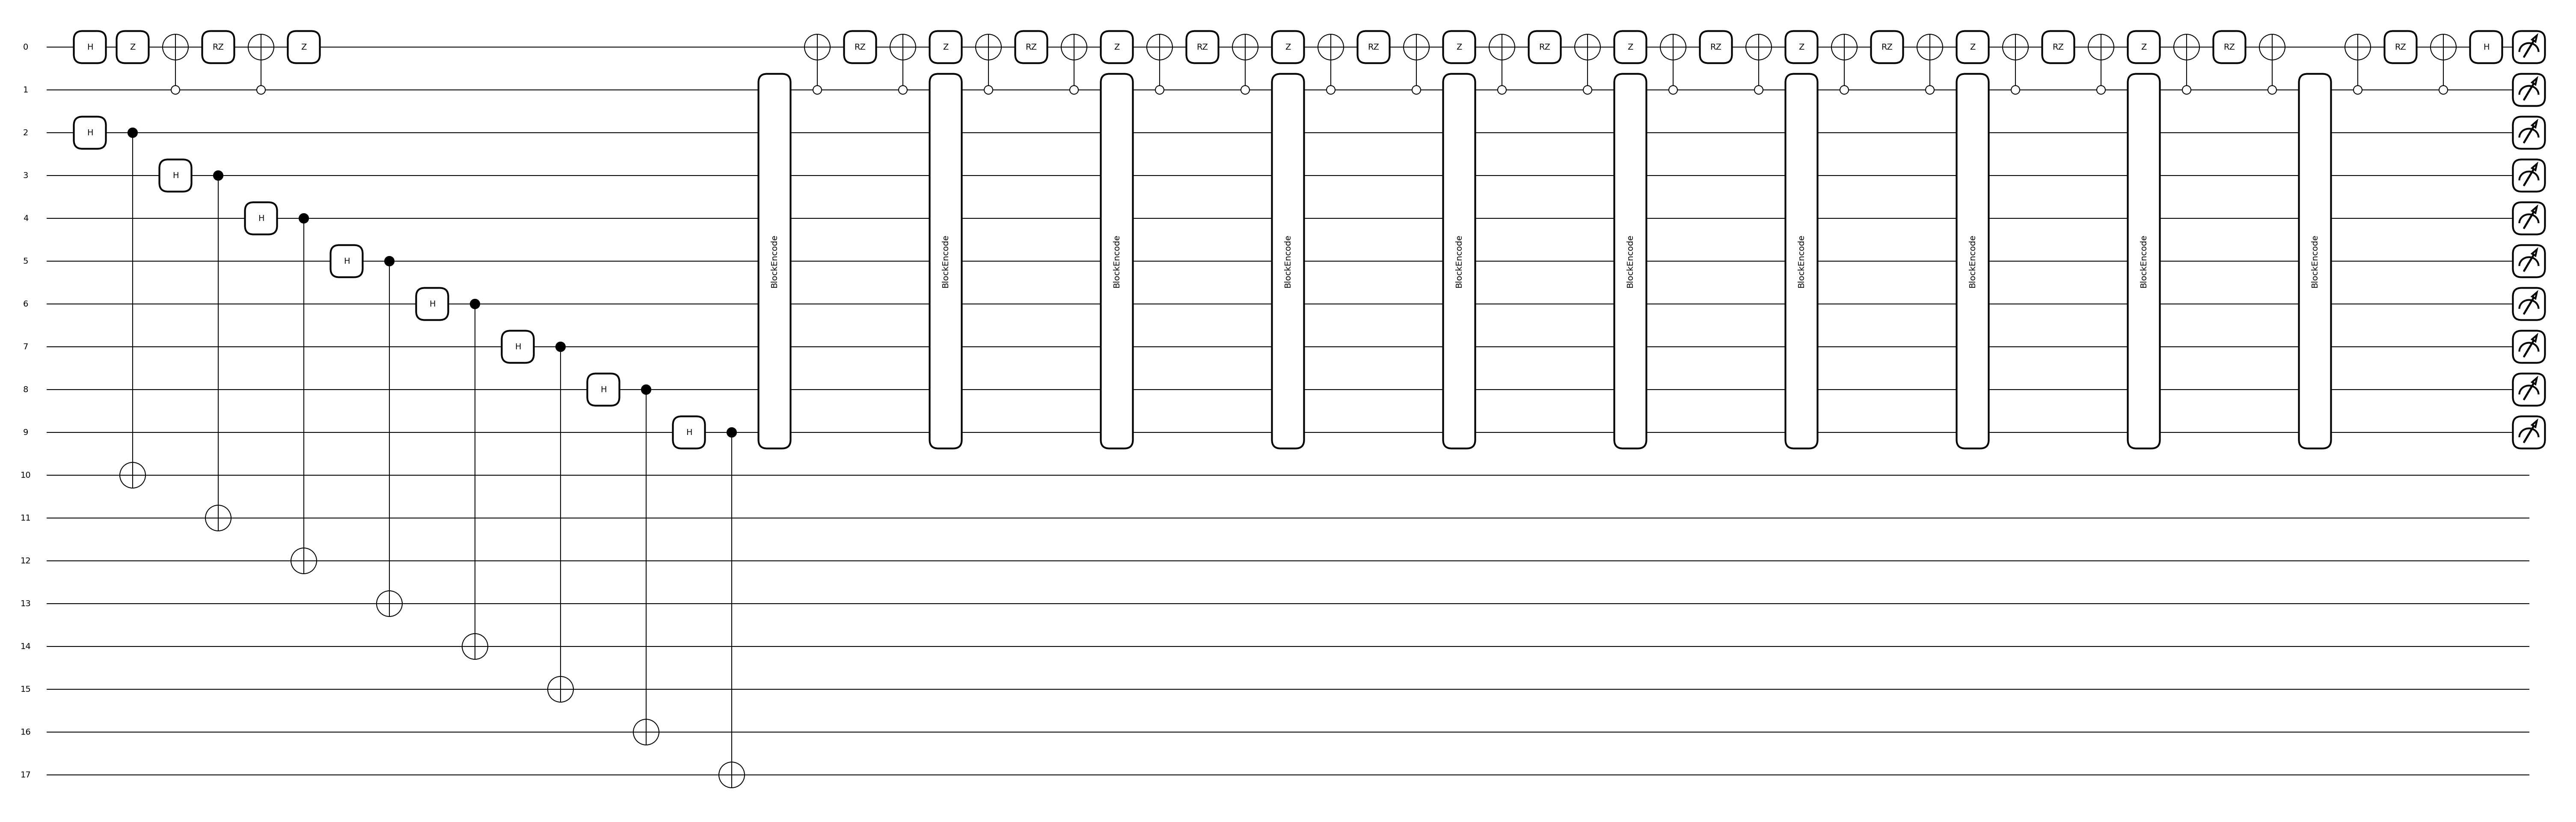

In [51]:
dev = qml.device('default.qubit', wires=qbm.n_qubits())
@qml.qnode(dev)
def quantum_circuit():
    qbm._prepare()
    return qbm._measure()


qml.draw_mpl(quantum_circuit)()